### # This notebook focuses on creating new features, transforming existing ones, and preparing the dataset for modeling. Feature engineering is a critical step to improve the performance of machine learning models.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

In [15]:
# Load the processed dataset
processed_data_path = "../data/processed/cleaned_energy_data.csv"
df = pd.read_csv(processed_data_path)
df.head()

,SolarEnergy,WindEnergy,HydroEnergy,OtherRenewableEnergy,TotalRenewableEnergy,Country_Australia,Country_Brazil,Country_Canada,Country_China,Country_France,Country_Germany,Country_India,Country_Japan,Country_UK,Country_USA,Year
0,-0.337886,1.546596,0.937605,0.251720,1.423478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2000
1,-1.064628,-1.214041,-1.358563,1.190797,-1.827414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2001
2,0.415641,0.703726,-1.486331,1.554937,-0.239904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2002
3,1.184973,-1.018315,-0.936947,-1.205960,-0.983877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2003
4,-0.571677,0.066936,-0.084731,-0.827460,-0.400771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2004


In [16]:
df.shape,df.columns

((240, 16),
 Index(['SolarEnergy', 'WindEnergy', 'HydroEnergy', 'OtherRenewableEnergy',
        'TotalRenewableEnergy', 'Country_Australia', 'Country_Brazil',
        'Country_Canada', 'Country_China', 'Country_France', 'Country_Germany',
        'Country_India', 'Country_Japan', 'Country_UK', 'Country_USA', 'Year'],
       dtype='object'))

In [17]:
# Reconstruct the 'Country' column from one-hot encoded columns
# Extract the country name from the one-hot encoded columns
country_columns = [col for col in df.columns if col.startswith('Country_')]
df['Country'] = df[country_columns].idxmax(axis=1).str.replace('Country_', '')

In [18]:
# Drop the one-hot encoded country columns 
df.drop(columns=country_columns, inplace=True)

In [19]:
df.head()

,SolarEnergy,WindEnergy,HydroEnergy,OtherRenewableEnergy,TotalRenewableEnergy,Year,Country
0,-0.337886,1.546596,0.937605,0.251720,1.423478,2000,USA
1,-1.064628,-1.214041,-1.358563,1.190797,-1.827414,2001,USA
2,0.415641,0.703726,-1.486331,1.554937,-0.239904,2002,USA
3,1.184973,-1.018315,-0.936947,-1.205960,-0.983877,2003,USA
4,-0.571677,0.066936,-0.084731,-0.827460,-0.400771,2004,USA


In [22]:
# Create new features
df['TotalRenewableEnergyPerCapita'] = df['TotalRenewableEnergy'] / 1_000_000  # Example scaling
df['SolarToWindRatio'] = df['SolarEnergy'] / (df['WindEnergy'] + 1e-6)  # Add small value to avoid division by zero
df['HydroToOtherRatio'] = df['HydroEnergy'] / (df['OtherRenewableEnergy'] + 1e-6)
df['YearlyGrowthRate'] = df.groupby('Country')['TotalRenewableEnergy'].pct_change() * 100
df.head()

,SolarEnergy,WindEnergy,HydroEnergy,OtherRenewableEnergy,TotalRenewableEnergy,Year,Country,TotalRenewableEnergyPerCapita,SolarToWindRatio,HydroToOtherRatio,YearlyGrowthRate
0,-0.337886,1.546596,0.937605,0.251720,1.423478,2000,USA,1.423478e-06,-0.218470,3.724774,NaN
1,-1.064628,-1.214041,-1.358563,1.190797,-1.827414,2001,USA,-1.827414e-06,0.876930,-1.140884,-228.376731
2,0.415641,0.703726,-1.486331,1.554937,-0.239904,2002,USA,-2.399037e-07,0.590628,-0.955878,-86.871960
3,1.184973,-1.018315,-0.936947,-1.205960,-0.983877,2003,USA,-9.838768e-07,-1.163662,0.776931,310.113292
4,-0.571677,0.066936,-0.084731,-0.827460,-0.400771,2004,USA,-4.007708e-07,-8.540493,0.102399,-59.266155


In [23]:
# Handle infinite or NaN values in new features
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)  # Fill NaN values with 0

In [ ]:
# Create polynomial features for numerical columns
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(df[['SolarEnergy', 'WindEnergy']])

In [26]:
# Convert to DataFrame
poly_df = pd.DataFrame(poly_features, columns=['SolarEnergy', 'WindEnergy', 'SolarEnergy_WindEnergy'])

In [28]:
# Add polynomial features to the main DataFrame
df = pd.concat([df, poly_df], axis=1)
df.head()

,SolarEnergy,WindEnergy,HydroEnergy,OtherRenewableEnergy,TotalRenewableEnergy,Year,Country,TotalRenewableEnergyPerCapita,SolarToWindRatio,HydroToOtherRatio,YearlyGrowthRate,SolarEnergy,WindEnergy,SolarEnergy_WindEnergy,SolarEnergy,WindEnergy,SolarEnergy_WindEnergy
0,-0.337886,1.546596,0.937605,0.251720,1.423478,2000,USA,1.423478e-06,-0.218470,3.724774,0.000000,-0.337886,1.546596,-0.522572,-0.337886,1.546596,-0.522572
1,-1.064628,-1.214041,-1.358563,1.190797,-1.827414,2001,USA,-1.827414e-06,0.876930,-1.140884,-228.376731,-1.064628,-1.214041,1.292502,-1.064628,-1.214041,1.292502
2,0.415641,0.703726,-1.486331,1.554937,-0.239904,2002,USA,-2.399037e-07,0.590628,-0.955878,-86.871960,0.415641,0.703726,0.292497,0.415641,0.703726,0.292497
3,1.184973,-1.018315,-0.936947,-1.205960,-0.983877,2003,USA,-9.838768e-07,-1.163662,0.776931,310.113292,1.184973,-1.018315,-1.206676,1.184973,-1.018315,-1.206676
4,-0.571677,0.066936,-0.084731,-0.827460,-0.400771,2004,USA,-4.007708e-07,-8.540493,0.102399,-59.266155,-0.571677,0.066936,-0.038266,-0.571677,0.066936,-0.038266


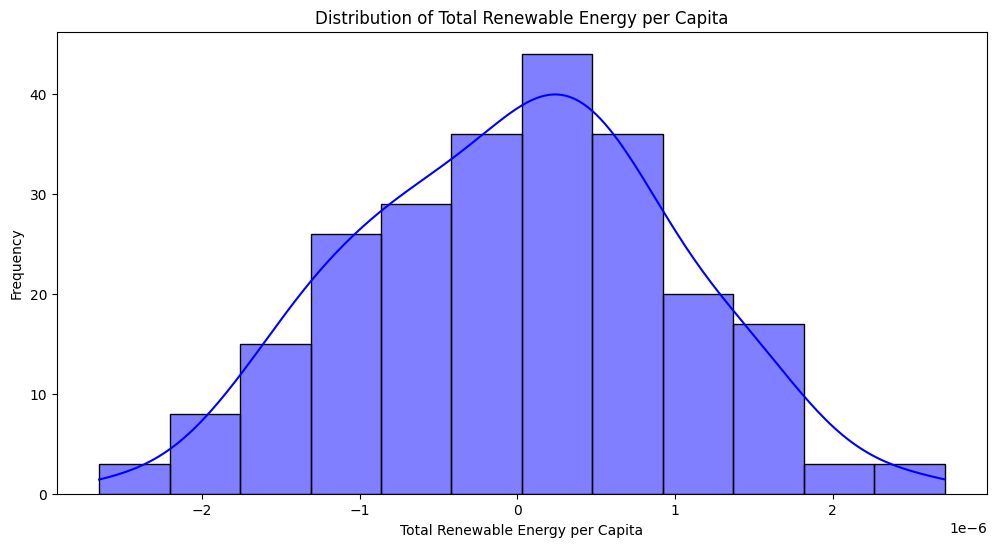

In [29]:
# Visualize the distribution of new features
plt.figure(figsize=(12, 6))
sns.histplot(df['TotalRenewableEnergyPerCapita'], kde=True, color='blue')
plt.title("Distribution of Total Renewable Energy per Capita")
plt.xlabel("Total Renewable Energy per Capita")
plt.ylabel("Frequency")
plt.show()


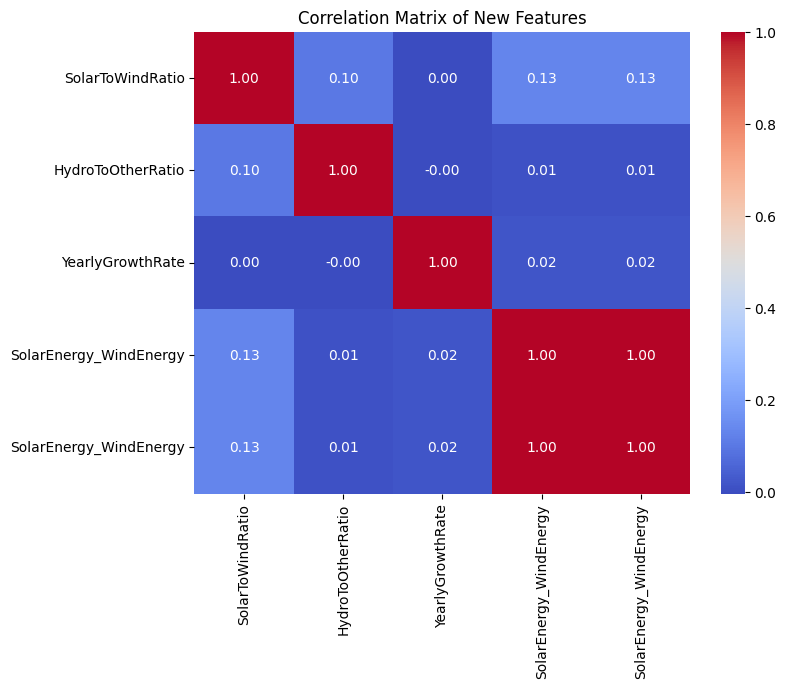

In [30]:
# Visualize the correlation matrix of new features
corr_matrix = df[['SolarToWindRatio', 'HydroToOtherRatio', 'YearlyGrowthRate', 'SolarEnergy_WindEnergy']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of New Features")
plt.show()

In [31]:
# Save the dataset with new features
feature_engineered_data_path = "../data/processed/feature_engineered_energy_data.csv"
df.to_csv(feature_engineered_data_path, index=False)
print(f"Feature-engineered data saved to {feature_engineered_data_path}")


Feature-engineered data saved to ../data/processed/feature_engineered_energy_data.csv


In [32]:
print("""
Summary of Feature Engineering:
1. Reconstructed the 'Country' column from one-hot encoded columns.
2. Created new features:
   - Total Renewable Energy per Capita
   - Solar to Wind Energy Ratio
   - Hydro to Other Renewable Energy Ratio
   - Yearly Growth Rate of Total Renewable Energy
3. Added polynomial features for SolarEnergy and WindEnergy.
4. Handled infinite and NaN values in new features.
5. Visualized the distribution and correlations of new features.
6. Saved the feature-engineered dataset to a new CSV file.
""")


Summary of Feature Engineering:
1. Reconstructed the 'Country' column from one-hot encoded columns.
2. Created new features:
   - Total Renewable Energy per Capita
   - Solar to Wind Energy Ratio
   - Hydro to Other Renewable Energy Ratio
   - Yearly Growth Rate of Total Renewable Energy
3. Added polynomial features for SolarEnergy and WindEnergy.
4. Handled infinite and NaN values in new features.
5. Visualized the distribution and correlations of new features.
6. Saved the feature-engineered dataset to a new CSV file.

